## Random balanced network (alpha synapses) connected with NEST
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/brunel_alpha_nest.html
* Brunel N (2000). Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8, 183-208.

In [2]:
import time

import matplotlib.pyplot as plt
import nest
import nest.raster_plot
import numpy as np
import scipy.special as sp

[admin:1444928] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.admin.1000/jf.0/2836398080/shared_mem_cuda_pool.admin could be created.
[admin:1444928] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Oct  2 2024 11:54:50

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
def LambertWm1(x):
    # Using scipy to mimic the gsl_sf_lambert_Wm1 function.
    return sp.lambertw(x, k=-1 if x < 0 else 0).real


def ComputePSPnorm(tauMem, CMem, tauSyn):
    a = tauMem / tauSyn
    b = 1.0 / tauSyn - 1.0 / tauMem

    # time of maximum
    t_max = 1.0 / b * (-LambertWm1(-np.exp(-1.0 / a) / a) - 1.0 / a)

    # maximum of PSP for current of unit amplitude
    return (
        np.exp(1.0)
        / (tauSyn * CMem * b)
        * ((np.exp(-t_max / tauMem) - np.exp(-t_max / tauSyn)) / b - t_max * np.exp(-t_max / tauSyn))
    )


nest.ResetKernel()

In [4]:
startbuild = time.time()

In [5]:
nest.local_num_threads = 20

dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5  # synaptic delay in ms

g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

tauSyn = 0.5  # synaptic time constant in ms
tauMem = 20.0  # time constant of membrane potential in ms
CMem = 250.0  # capacitance of membrane in in pF
theta = 20.0  # membrane threshold potential in mV
neuron_params = {
    "C_m": CMem,
    "tau_m": tauMem,
    "tau_syn_ex": tauSyn,
    "tau_syn_in": tauSyn,
    "t_ref": 2.0,
    "E_L": 0.0,
    "V_reset": 0.0,
    "V_m": 0.0,
    "V_th": theta,
}
J = 0.1  # postsynaptic amplitude in mV
J_unit = ComputePSPnorm(tauMem, CMem, tauSyn)
J_ex = J / J_unit  # amplitude of excitatory postsynaptic current
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic current

nu_th = (theta * CMem) / (J_ex * CE * np.exp(1) * tauMem * tauSyn)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

nest.resolution = dt
nest.print_time = True
nest.overwrite_files = True

print("Building network")

Building network

Oct 02 21:36:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [6]:
nodes_ex = nest.Create("iaf_psc_alpha", NE, params=neuron_params)
nodes_in = nest.Create("iaf_psc_alpha", NI, params=neuron_params)
noise = nest.Create("poisson_generator", params={"rate": p_rate})
espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

In [7]:
espikes.set(label="data/brunel-py-ex", record_to="ascii")
ispikes.set(label="data/brunel-py-in", record_to="ascii")

print("Connecting devices")

Connecting devices


In [8]:
nest.CopyModel("static_synapse", "excitatory", {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory", {"weight": J_in, "delay": delay})

In [9]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

In [10]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


In [11]:
conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


In [12]:

conn_params_in = {"rule": "fixed_indegree", "indegree": CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")


In [13]:
endbuild = time.time()

In [14]:
print("Simulating")

nest.Simulate(simtime)

Simulating

Oct 02 21:36:34 NodeManager::prepare_nodes [Info]: 
    Preparing 12560 nodes for simulation.

Oct 02 21:36:34 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Oct 02 21:36:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12560
    Simulation time (ms): 1000
    Number of OpenMP threads: 20
    Number of MPI processes: 1

[ 100% ] Model time: 999.0 ms, Real-time factor: 1.5379.0 ms, Real-time factor: 1.5496117.0 ms, Real-time factor: 1.5525

Oct 02 21:36:36 SimulationManager::run [Info]: 
    Simulation finished.


In [15]:
endsimulate = time.time()

In [16]:
events_ex = espikes.n_events
events_in = ispikes.n_events

rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

In [17]:
num_synapses_ex = nest.GetDefaults("excitatory")["num_connections"]
num_synapses_in = nest.GetDefaults("inhibitory")["num_connections"]
num_synapses = num_synapses_ex + num_synapses_in

In [18]:
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

In [19]:
print("Brunel network simulation (Python)")
print(f"Number of neurons : {N_neurons}")
print(f"Number of synapses: {num_synapses}")
print(f"       Excitatory : {num_synapses_ex}")
print(f"       Inhibitory : {num_synapses_in}")
print(f"Excitatory rate   : {rate_ex:.2f} Hz")
print(f"Inhibitory rate   : {rate_in:.2f} Hz")
print(f"Building time     : {build_time:.2f} s")
print(f"Simulation time   : {sim_time:.2f} s")

Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Excitatory : 12512600
       Inhibitory : 3125000
Excitatory rate   : 28.76 Hz
Inhibitory rate   : 28.62 Hz
Building time     : 0.54 s
Simulation time   : 2.08 s


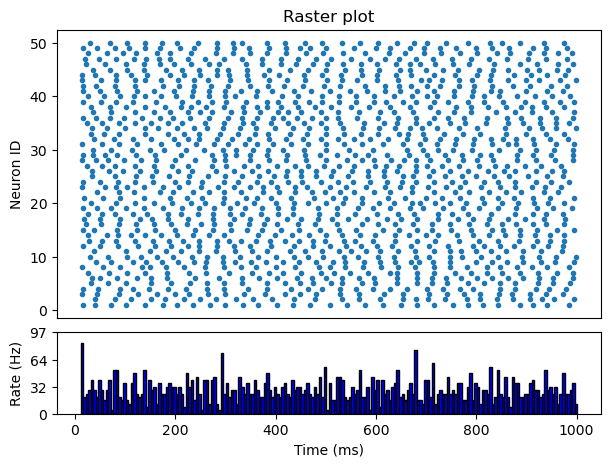

In [20]:
nest.raster_plot.from_device(espikes, hist=True)
plt.show()

In [21]:
help(nest.Create)


Help on function Create in module nest.lib.hl_api_nodes:

Create(model, n=1, params=None, positions=None)
    Create one or more nodes.

    Generates `n` new network objects of the supplied model type. If `n` is not
    given, a single node is created. Note that if setting parameters of the
    nodes fail, the nodes will still have been created.

    Note
    ----
    During network construction, create all nodes representing model neurons first, then all nodes
    representing devices (generators, recorders, or detectors), or all devices first and then all neurons.
    Otherwise, network connection can be slow, especially in parallel simulations of networks
    with many devices.

    Parameters
    ----------
    model : str
        Name of the model to create
    n : int, optional
        Number of nodes to create
    params : dict or list, optional
        Parameters for the new nodes. Can be any of the following:

        - A dictionary with either single values or lists of size 